In [1]:
import sys
import os
from pathlib import Path
import polars as pl

In [ ]:
#os.chdir("../..") # run once

In [3]:
Path.cwd()

PosixPath('/home/lluis/master-thesis/CSISD')

In [4]:
project_root = os.path.abspath("../../")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.io.pitch_io import load_pitch_file
from settings import PREPROCESSED_PITCH_PATH
from src.features.peak_detection import find_all_peaks, add_peak_columns, extrema_to_dataframe

# from src.features.peak_detection import extract_local_extrema, extrema_to_dataframe, mark_peaks

In [5]:
print(PREPROCESSED_PITCH_PATH)

data/interim/srs_v1_bdn_sav/pitch/srs_v1_bdn_sav_pitch_preprocessed.parquet


In [6]:
df_pitch = load_pitch_file(file_path=PREPROCESSED_PITCH_PATH)

df_pitch


time_rel_sec,f0_Hz,f0_pchip,f0_savgol_p3_w13,f0_savgol_p3_w27
f32,f32,f32,f32,f32
0.0,0.0,NaN,NaN,NaN
0.010001,0.0,NaN,NaN,NaN
0.020001,0.0,NaN,NaN,NaN
0.030002,0.0,NaN,NaN,NaN
0.040003,0.0,NaN,NaN,NaN
…,…,…,…,…
438.02774,0.0,NaN,NaN,NaN
438.03775,0.0,NaN,NaN,NaN
438.04776,0.0,NaN,NaN,NaN


In [7]:
# 1. Troba els índexs dels extrema (incloent-hi plats)
extrema_idx = find_all_peaks(
    df_pitch,
    "f0_pchip",
    plateau_size=2,
    neighborhood=1,
    return_all_points=True
)

In [8]:


# 2. Afegeix les columnes de màxims i mínims al DataFrame original
df_pitch_extrema = add_peak_columns(
    df_pitch,
    "f0_pchip",
    plateau_size=2,
    neighborhood=1,
    include_edges=True
)

In [9]:

# 3. Crea un DataFrame amb només els extrema
df_only_extrema = extrema_to_dataframe(
    df_pitch_extrema,
    extrema_idx,
    "f0_pchip",
    extra_cols=["svara_mark"],
    plateau_size=2,
    neighborhood=1
)

In [10]:



# 4. Visualitza els resultats
#print(df_pitch_extrema)

type(df_pitch_extrema.schema)

polars.schema.Schema

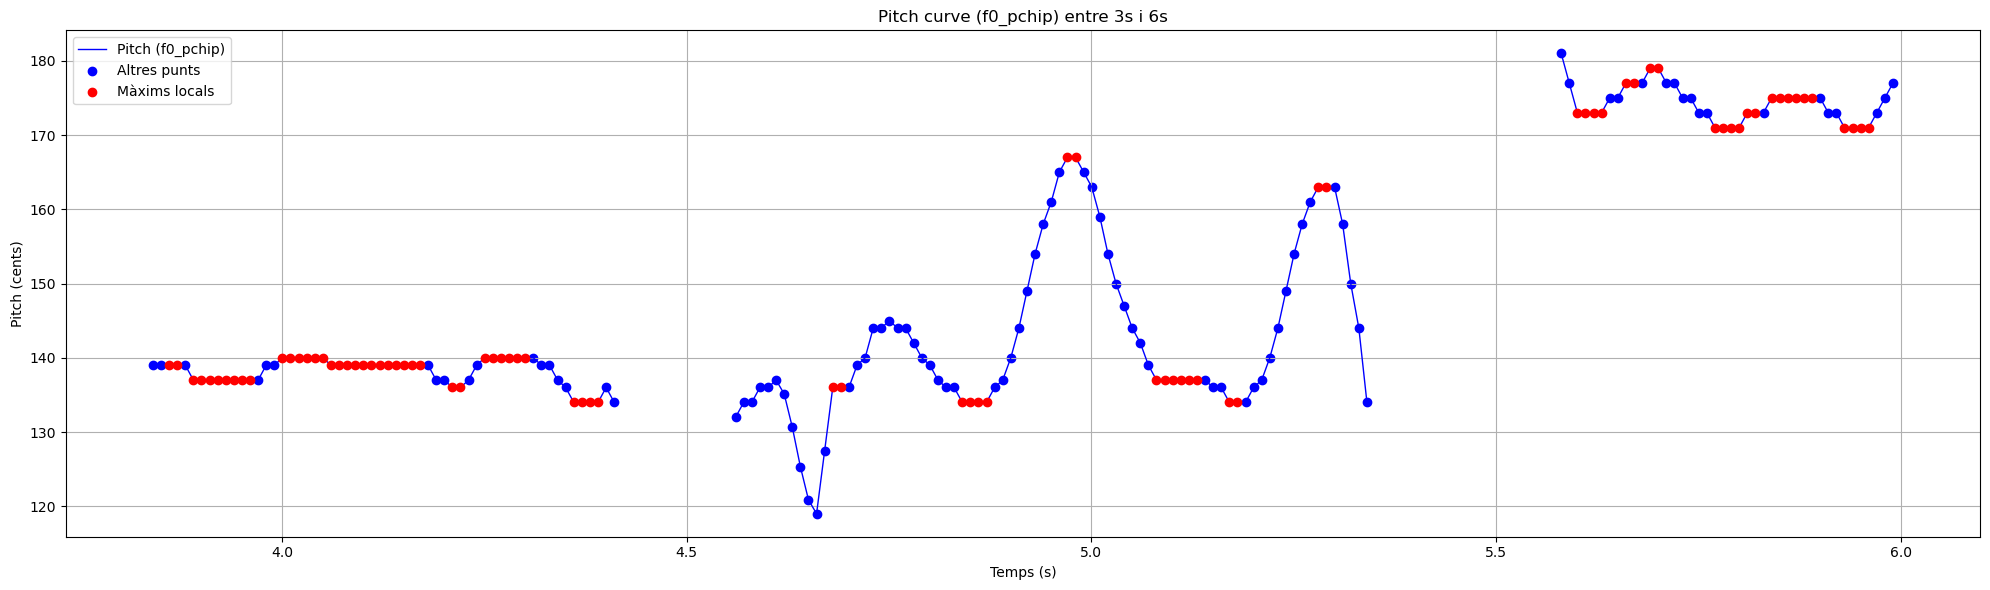

In [11]:
import polars as pl
import matplotlib.pyplot as plt

# Suposa que df_pitch és el teu DataFrame de Polars
# Exemple de filtre per interval de temps (ajusta x_min i x_max)
x_min, x_max = 3, 6
df_filtrat = df_pitch_extrema.filter(
    (pl.col("time_rel_sec") >= x_min) &
    (pl.col("time_rel_sec") <= x_max)
)

# Crea la figura
plt.figure(figsize=(20, 6))

# Pinta la línia de la corba sense marcadors
plt.plot(
    df_filtrat["time_rel_sec"],
    df_filtrat["f0_pchip"],
    color="blue",
    linewidth=1,
    label="Pitch (f0_pchip)"
)

# Pinta els punts no extrema de blau (opcional, si vols marcadors)
plt.scatter(
    df_filtrat.filter(~pl.col("is_peak_max") & ~pl.col("is_peak_min"))["time_rel_sec"],
    df_filtrat.filter(~pl.col("is_peak_max") & ~pl.col("is_peak_min"))["f0_pchip"],
    color="blue",
    marker="o",
    label="Altres punts"
)

# Pinta els màxims i mínims de vermell
plt.scatter(
    df_filtrat.filter(pl.col("is_peak_max"))["time_rel_sec"],
    df_filtrat.filter(pl.col("is_peak_max"))["f0_pchip"],
    color="red",
    marker="o",
    label="Màxims locals",
    zorder=5
)
plt.scatter(
    df_filtrat.filter(pl.col("is_peak_min"))["time_rel_sec"],
    df_filtrat.filter(pl.col("is_peak_min"))["f0_pchip"],
    color="red",
    marker="o",
    zorder=5
)

# Afegeix etiquetes i llegenda
plt.xlabel("Temps (s)")
plt.ylabel("Pitch (cents)")
plt.title(f"Pitch curve (f0_pchip) entre {x_min}s i {x_max}s")
plt.grid(True)
plt.legend()
plt.tight_layout()  # Ajusta els marges
plt.show()

In [ ]:
'''
df_pitch = load_pitch_file(file_path=PREPROCESSED_PITCH_PATH)

df_pitch

local_extrema_idx = extract_local_extrema(df=df_pitch, col= 'f0_pchip', include_edges=True, gt_zero=False, strict=False)

local_extrema_idx

df_extrema = extrema_to_dataframe(df=df_pitch, extrema_idx=local_extrema_idx, col='f0_pchip')

print(df_extrema)

df_pitch = mark_peaks(df=df_pitch, pitch_col="f0_pchip")
'''


'\ndf_pitch = load_pitch_file(file_path=PREPROCESSED_PITCH_PATH)\n\ndf_pitch\n\nlocal_extrema_idx = extract_local_extrema(df=df_pitch, col= \'f0_pchip\', include_edges=True, gt_zero=False, strict=False)\n\nlocal_extrema_idx\n\ndf_extrema = extrema_to_dataframe(df=df_pitch, extrema_idx=local_extrema_idx, col=\'f0_pchip\')\n\nprint(df_extrema)\n\ndf_pitch = mark_peaks(df=df_pitch, pitch_col="f0_pchip")\n'